# Agents

AutoGen AgentChat provides a set of preset Agents, each with variations in how an agent might respond to messages.
All agents share the following attributes and methods:

- {py:attr}`~autogen_agentchat.agents.BaseChatAgent.name`: The unique name of the agent.
- {py:attr}`~autogen_agentchat.agents.BaseChatAgent.description`: The description of the agent in text.
- {py:attr}`~autogen_agentchat.agents.BaseChatAgent.run`: The method that runs the agent given a task as a string or a list of messages, and returns a {py:class}`~autogen_agentchat.base.TaskResult`. **Agents are expected to be stateful and this method is expected to be called with new messages, not complete history**.
- {py:attr}`~autogen_agentchat.agents.BaseChatAgent.run_stream`: Same as {py:meth}`~autogen_agentchat.agents.BaseChatAgent.run` but returns an iterator of messages that subclass {py:class}`~autogen_agentchat.messages.BaseAgentEvent` or {py:class}`~autogen_agentchat.messages.BaseChatMessage` followed by a {py:class}`~autogen_agentchat.base.TaskResult` as the last item.

See {py:mod}`autogen_agentchat.messages` for more information on AgentChat message types.

## Assistant Agent

{py:class}`~autogen_agentchat.agents.AssistantAgent` is a built-in agent that
uses a language model and has the ability to use tools.

```{warning}
{py:class}`~autogen_agentchat.agents.AssistantAgent` is a "kitchen sink" agent
for prototyping and educational purpose -- it is very general.
Make sure you read the documentation and implementation to understand the design choices.
Once you fully understand the design, you may want to implement your own agent.
See [Custom Agent](../custom-agents.ipynb).
```

In [2]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import StructuredMessage
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient

In [3]:
# Define a tool that searches the web for information.
# For simplicity, we will use a mock function here that returns a static string.
async def web_search(query: str) -> str:
    """Find information on the web"""
    return "AutoGen is a programming framework for building multi-agent applications."


# Create an agent that uses the OpenAI GPT-4o model.
model_client = OpenAIChatCompletionClient(
    model="gpt-4.1-nano",
    # api_key="YOUR_API_KEY",
)
agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
)

## Getting Result

We can use the {py:meth}`~autogen_agentchat.agents.BaseChatAgent.run` method to get the agent run on a given task.

In [3]:
# Use asyncio.run(agent.run(...)) when running in a script.
result = await agent.run(task="Find information on AutoGen")
print(result.messages)

[TextMessage(source='user', models_usage=None, metadata={}, content='Find information on AutoGen', type='TextMessage'), ToolCallRequestEvent(source='assistant', models_usage=RequestUsage(prompt_tokens=61, completion_tokens=16), metadata={}, content=[FunctionCall(id='call_703i17OLXfztkuioUbkESnea', arguments='{"query":"AutoGen"}', name='web_search')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='assistant', models_usage=None, metadata={}, content=[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', name='web_search', call_id='call_703i17OLXfztkuioUbkESnea', is_error=False)], type='ToolCallExecutionEvent'), ToolCallSummaryMessage(source='assistant', models_usage=None, metadata={}, content='AutoGen is a programming framework for building multi-agent applications.', type='ToolCallSummaryMessage')]


The call to the {py:meth}`~autogen_agentchat.agents.BaseChatAgent.run` method
returns a {py:class}`~autogen_agentchat.base.TaskResult`
with the list of messages in the {py:attr}`~autogen_agentchat.base.TaskResult.messages` attribute,
which stores the agent's "thought process" as well as the final response.

```{note}
It is important to note that {py:meth}`~autogen_agentchat.agents.BaseChatAgent.run`
will update the internal state of the agent -- it will add the messages to the agent's
message history. You can also call {py:meth}`~autogen_agentchat.agents.BaseChatAgent.run`
without a task to get the agent to generate responses given its current state.
```

```{note}
Unlike in v0.2 AgentChat, the tools are executed by the same agent directly within
the same call to {py:meth}`~autogen_agentchat.agents.BaseChatAgent.run`.
By default, the agent will return the result of the tool call as the final response.
```

## Multi-Modal Input

The {py:class}`~autogen_agentchat.agents.AssistantAgent` can handle multi-modal input
by providing the input as a {py:class}`~autogen_agentchat.messages.MultiModalMessage`.


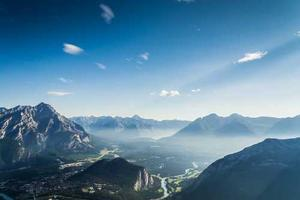

In [15]:
from io import BytesIO

import PIL
import requests
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image

# Create a multi-modal message with random image and text.
pil_image = PIL.Image.open(BytesIO(requests.get("https://picsum.photos/300/200").content))
img = Image(pil_image)
multi_modal_message = MultiModalMessage(content=["Can you describe the content of this image?", img], source="user")
img

In [17]:
# Use asyncio.run(...) when running in a script.
result = await agent.run(task=multi_modal_message)
print(result.messages[-1].content)  # type: ignore

The image depicts a scenic mountain landscape under a clear blue sky. There are several rugged mountain peaks in the background, with some clouds scattered across the sky. In the valley below, there is a body of water, possibly a lake or river, surrounded by greenery. The overall scene conveys a sense of natural beauty and tranquility.


## Streaming Messages

We can also stream each message as it is generated by the agent by using the
{py:meth}`~autogen_agentchat.agents.BaseChatAgent.run_stream` method,
and use {py:class}`~autogen_agentchat.ui.Console` to print the messages
as they appear to the console.

In [21]:
async def assistant_run_stream() -> None:
    # Option 1: read each message from the stream (as shown in the previous example).
    # async for message in agent.run_stream(task="Find information on AutoGen"):
    #     print(message)

    # Option 2: use Console to print all messages as they appear.
    await Console(
        agent.run_stream(task="Find information on AutoGen"),
        output_stats=True,  # Enable stats printing.
    )


# Use asyncio.run(assistant_run_stream()) when running in a script.
await assistant_run_stream()

---------- TextMessage (user) ----------
Find information on AutoGen
---------- ToolCallRequestEvent (assistant) ----------
[FunctionCall(id='call_HOTRhOzXCBm0zSqZCFbHD7YP', arguments='{"query":"AutoGen"}', name='web_search')]
[Prompt tokens: 61, Completion tokens: 16]
---------- ToolCallExecutionEvent (assistant) ----------
[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', name='web_search', call_id='call_HOTRhOzXCBm0zSqZCFbHD7YP', is_error=False)]
---------- ToolCallSummaryMessage (assistant) ----------
AutoGen is a programming framework for building multi-agent applications.
---------- Summary ----------
Number of messages: 4
Finish reason: None
Total prompt tokens: 61
Total completion tokens: 16
Duration: 0.52 seconds


The {py:meth}`~autogen_agentchat.agents.BaseChatAgent.run_stream` method
returns an asynchronous generator that yields each message generated by the agent,
followed by a {py:class}`~autogen_agentchat.base.TaskResult` as the last item.

From the messages, you can observe that the assistant agent utilized the `web_search` tool to
gather information and responded based on the search results.

## Using Tools and Workbench

Large Language Models (LLMs) are typically limited to generating text or code responses. 
However, many complex tasks benefit from the ability to use external tools that perform specific actions,
such as fetching data from APIs or databases.

To address this limitation, modern LLMs can now accept a list of available tool schemas 
(descriptions of tools and their arguments) and generate a tool call message. 
This capability is known as **Tool Calling** or **Function Calling** and 
is becoming a popular pattern in building intelligent agent-based applications.
Refer to the documentation from [OpenAI](https://platform.openai.com/docs/guides/function-calling) 
and [Anthropic](https://docs.anthropic.com/en/docs/build-with-claude/tool-use) for more information about tool calling in LLMs.

In AgentChat, the {py:class}`~autogen_agentchat.agents.AssistantAgent` can use tools to perform specific actions.
The `web_search` tool is one such tool that allows the assistant agent to search the web for information.
A single custom tool can be a Python function or a subclass of the {py:class}`~autogen_core.tools.BaseTool`.

On the other hand, a {py:class}`~autogen_core.tools.Workbench` is a collection of tools that share state and resources.

```{note}
For how to use model clients directly with tools and workbench, refer to the [Tools](../../core-user-guide/components/tools.ipynb)
and [Workbench](../../core-user-guide/components/workbench.ipynb) sections
in the Core User Guide.
```

By default, when {py:class}`~autogen_agentchat.agents.AssistantAgent` executes a tool,
it will return the tool's output as a string in {py:class}`~autogen_agentchat.messages.ToolCallSummaryMessage` in its response.
If your tool does not return a well-formed string in natural language, you
can add a reflection step to have the model summarize the tool's output,
by setting the `reflect_on_tool_use=True` parameter in the {py:class}`~autogen_agentchat.agents.AssistantAgent` constructor.

### Built-in Tools and Workbench

AutoGen Extension provides a set of built-in tools that can be used with the Assistant Agent.
Head over to the [API documentation](../../../reference/index.md) for all the available tools
under the `autogen_ext.tools` namespace. For example, you can find the following tools:

- {py:mod}`~autogen_ext.tools.graphrag`: Tools for using GraphRAG index.
- {py:mod}`~autogen_ext.tools.http`: Tools for making HTTP requests.
- {py:mod}`~autogen_ext.tools.langchain`: Adaptor for using LangChain tools.
- {py:mod}`~autogen_ext.tools.mcp`: Tools and workbench for using Model Chat Protocol (MCP) servers.

### Function Tool

The {py:class}`~autogen_agentchat.agents.AssistantAgent` automatically
converts a Python function into a {py:class}`~autogen_core.tools.FunctionTool`
which can be used as a tool by the agent and automatically generates the tool schema
from the function signature and docstring.

The `web_search_func` tool is an example of a function tool.
The schema is automatically generated.

In [ ]:
from autogen_core.tools import FunctionTool


# Define a tool using a Python function.
async def web_search_func(query: str) -> str:
    """Find information on the web"""
    return "AutoGen is a programming framework for building multi-agent applications."


# This step is automatically performed inside the AssistantAgent if the tool is a Python function.
web_search_function_tool = FunctionTool(web_search_func, description="Find information on the web")
# The schema is provided to the model during AssistantAgent's on_messages call.
web_search_function_tool.schema

{'name': 'web_search_func',
 'description': 'Find information on the web',
 'parameters': {'type': 'object',
  'properties': {'query': {'description': 'query',
    'title': 'Query',
    'type': 'string'}},
  'required': ['query'],
  'additionalProperties': False},
 'strict': False}

### Model Context Protocol (MCP) Workbench

The {py:class}`~autogen_agentchat.agents.AssistantAgent` can also use tools that are
served from a Model Context Protocol (MCP) server
using {py:func}`~autogen_ext.tools.mcp.McpWorkbench`.

In [ ]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_ext.tools.mcp import McpWorkbench, StdioServerParams

# Get the fetch tool from mcp-server-fetch.
fetch_mcp_server = StdioServerParams(command="uvx", args=["mcp-server-fetch"])

# Create an MCP workbench which provides a session to the mcp server.
async with McpWorkbench(fetch_mcp_server) as workbench:  # type: ignore
    # Create an agent that can use the fetch tool.
    model_client = OpenAIChatCompletionClient(model="gpt-4.1-nano")
    fetch_agent = AssistantAgent(
        name="fetcher", model_client=model_client, workbench=workbench, reflect_on_tool_use=True
    )

    # Let the agent fetch the content of a URL and summarize it.
    result = await fetch_agent.run(task="Summarize the content of https://en.wikipedia.org/wiki/Seattle")
    assert isinstance(result.messages[-1], TextMessage)
    print(result.messages[-1].content)

    # Close the connection to the model client.
    await model_client.close()

Seattle is a major city located in the state of Washington, United States. It was founded on November 13, 1851, and incorporated as a town on January 14, 1865, and later as a city on December 2, 1869. The city is named after Chief Seattle. It covers an area of approximately 142 square miles, with a population of around 737,000 as of the 2020 Census, and an estimated 755,078 residents in 2023. Seattle is known by nicknames such as The Emerald City, Jet City, and Rain City, and has mottos including The City of Flowers and The City of Goodwill. The city operates under a mayor–council government system, with Bruce Harrell serving as mayor. Key landmarks include the Space Needle, Pike Place Market, Amazon Spheres, and the Seattle Great Wheel. It is situated on the U.S. West Coast, with a diverse urban and metropolitan area that extends to a population of over 4 million in the greater metropolitan region.


### Agent as a Tool

Any {py:class}`~autogen_agentchat.agents.BaseChatAgent` can be used as a tool
by wrapping it in a {py:class}`~autogen_agentchat.tools.AgentTool`.
This allows for a dynamic, model-driven multi-agent workflow where
the agent can call other agents as tools to solve tasks.

### Parallel Tool Calls

Some models support parallel tool calls, which can be useful for tasks that require multiple tools to be called simultaneously.
By default, if the model client produces multiple tool calls, {py:class}`~autogen_agentchat.agents.AssistantAgent`
will call the tools in parallel.

You may want to disable parallel tool calls when the tools have side effects that may interfere with each other, or,
when agent behavior needs to be consistent across different models.
This should be done at the model client level.

For {py:class}`~autogen_ext.models.openai.OpenAIChatCompletionClient` and {py:class}`~autogen_ext.models.openai.AzureOpenAIChatCompletionClient`,
set `parallel_tool_calls=False` to disable parallel tool calls.

In [5]:
model_client_no_parallel_tool_call = OpenAIChatCompletionClient(
    model="gpt-4o",
    parallel_tool_calls=False,  # type: ignore
)
agent_no_parallel_tool_call = AssistantAgent(
    name="assistant",
    model_client=model_client_no_parallel_tool_call,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
)

### Tool Iterations

One model call followed by one tool call or parallel tool calls
is a single tool iteration.
By default, the {py:class}`~autogen_agentchat.agents.AssistantAgent` will
execute at most one iteration.

The agent can be configured to execute multiple iterations until the model
stops generating tool calls or the maximum number of iterations is reached.
You can control the maximum number of iterations by setting the `max_tool_iterations` parameter
in the {py:class}`~autogen_agentchat.agents.AssistantAgent` constructor.

In [6]:
agent_loop = AssistantAgent(
    name="assistant_loop",
    model_client=model_client_no_parallel_tool_call,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
    max_tool_iterations=10,  # At most 10 iterations of tool calls before stopping the loop.
)

## Structured Output

Structured output allows models to return structured JSON text with pre-defined schema
provided by the application. Different from JSON-mode, the schema can be provided
as a [Pydantic BaseModel](https://docs.pydantic.dev/latest/concepts/models/)
class, which can also be used to validate the output.

Once you specify the base model class in the `output_content_type` parameter
of the {py:class}`~autogen_agentchat.agents.AssistantAgent` constructor,
the agent will respond with a {py:class}`~autogen_agentchat.messages.StructuredMessage`
whose `content`'s type is the type of the base model class.

This way, you can integrate agent's response directly into your application
and use the model's output as a structured object.

```{note}
When the `output_content_type` is set, it by default requires the agent to reflect on the tool use
and return the a structured output message based on the tool call result.
You can disable this behavior by setting `reflect_on_tool_use=False` explictly.
```

Structured output is also useful for incorporating Chain-of-Thought
reasoning in the agent's responses.
See the example below for how to use structured output with the assistant agent.

In [ ]:
from typing import Literal

from pydantic import BaseModel


# The response format for the agent as a Pydantic base model.
class AgentResponse(BaseModel):
    thoughts: str
    response: Literal["happy", "sad", "neutral"]


# Create an agent that uses the OpenAI GPT-4o model.
model_client = OpenAIChatCompletionClient(model="gpt-4o")
agent = AssistantAgent(
    "assistant",
    model_client=model_client,
    system_message="Categorize the input as happy, sad, or neutral following the JSON format.",
    # Define the output content type of the agent.
    output_content_type=AgentResponse,
)

result = await Console(agent.run_stream(task="I am happy."))

# Check the last message in the result, validate its type, and print the thoughts and response.
assert isinstance(result.messages[-1], StructuredMessage)
assert isinstance(result.messages[-1].content, AgentResponse)
print("Thought: ", result.messages[-1].content.thoughts)
print("Response: ", result.messages[-1].content.response)
await model_client.close()

---------- user ----------
I am happy.


---------- assistant ----------
{
  "thoughts": "The user explicitly states they are happy.",
  "response": "happy"
}
Thought:  The user explicitly states they are happy.
Response:  happy


## Streaming Tokens

You can stream the tokens generated by the model client by setting `model_client_stream=True`.
This will cause the agent to yield {py:class}`~autogen_agentchat.messages.ModelClientStreamingChunkEvent` messages
in {py:meth}`~autogen_agentchat.agents.BaseChatAgent.run_stream`.

The underlying model API must support streaming tokens for this to work.
Please check with your model provider to see if this is supported.

In [25]:
model_client = OpenAIChatCompletionClient(model="gpt-4o")

streaming_assistant = AssistantAgent(
    name="assistant",
    model_client=model_client,
    system_message="You are a helpful assistant.",
    model_client_stream=True,  # Enable streaming tokens.
)

# Use an async function and asyncio.run() in a script.
async for message in streaming_assistant.run_stream(task="Name two cities in South America"):  # type: ignore
    print(message)

source='user' models_usage=None metadata={} content='Name two cities in South America' type='TextMessage'
source='assistant' models_usage=None metadata={} content='Two' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None metadata={} content=' cities' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None metadata={} content=' in' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None metadata={} content=' South' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None metadata={} content=' America' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None metadata={} content=' are' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None metadata={} content=' Buenos' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None metadata={} content=' Aires' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None metadata={} content=' in' typ

You can see the streaming chunks in the output above.
The chunks are generated by the model client and are yielded by the agent as they are received.
The final response, the concatenation of all the chunks, is yielded right after the last chunk.

## Using Model Context

{py:class}`~autogen_agentchat.agents.AssistantAgent` has a `model_context`
parameter that can be used to pass in a {py:class}`~autogen_core.model_context.ChatCompletionContext`
object. This allows the agent to use different model contexts, such as
{py:class}`~autogen_core.model_context.BufferedChatCompletionContext` to
limit the context sent to the model.

By default, {py:class}`~autogen_agentchat.agents.AssistantAgent` uses
the {py:class}`~autogen_core.model_context.UnboundedChatCompletionContext`
which sends the full conversation history to the model. To limit the context
to the last `n` messages, you can use the {py:class}`~autogen_core.model_context.BufferedChatCompletionContext`.
To limit the context by token count, you can use the
{py:class}`~autogen_core.model_context.TokenLimitedChatCompletionContext`.

In [ ]:
from autogen_core.model_context import BufferedChatCompletionContext

# Create an agent that uses only the last 5 messages in the context to generate responses.
agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
    model_context=BufferedChatCompletionContext(buffer_size=5),  # Only use the last 5 messages in the context.
)

## Other Preset Agents

The following preset agents are available:

- {py:class}`~autogen_agentchat.agents.UserProxyAgent`: An agent that takes user input returns it as responses.
- {py:class}`~autogen_agentchat.agents.CodeExecutorAgent`: An agent that can execute code.
- {py:class}`~autogen_ext.agents.openai.OpenAIAssistantAgent`: An agent that is backed by an OpenAI Assistant, with ability to use custom tools.
- {py:class}`~autogen_ext.agents.web_surfer.MultimodalWebSurfer`: A multi-modal agent that can search the web and visit web pages for information.
- {py:class}`~autogen_ext.agents.file_surfer.FileSurfer`: An agent that can search and browse local files for information.
- {py:class}`~autogen_ext.agents.video_surfer.VideoSurfer`: An agent that can watch videos for information.

## Next Step

Having explored the usage of the {py:class}`~autogen_agentchat.agents.AssistantAgent`, we can now proceed to the next section to learn about the teams feature in AgentChat.


<!-- ## CodingAssistantAgent

Generates responses (text and code) using an LLM upon receipt of a message. It takes a `system_message` argument that defines or sets the tone for how the agent's LLM should respond. 

```python

writing_assistant_agent = CodingAssistantAgent(
    name="writing_assistant_agent",
    system_message="You are a helpful assistant that solve tasks by generating text responses and code.",
    model_client=model_client,
)
`

We can explore or test the behavior of the agent by sending a message to it using the  {py:meth}`~autogen_agentchat.agents.BaseChatAgent.on_messages`  method. 

```python
result = await writing_assistant_agent.on_messages(
    messages=[
        TextMessage(content="What is the weather right now in France?", source="user"),
    ],
    cancellation_token=CancellationToken(),
)
print(result) -->